In [1]:
from agent import QAgent 
from environment01 import SingleStockEnv
from scaler import get_scaler
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import talib
import seaborn as sns
import torch
import numpy as np
import plotly.graph_objects as go
import pyfolio as pf
import empyrical
from tqdm.notebook import tqdm 
%matplotlib inline

C:\Users\User\anaconda3\envs\MyDjango\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


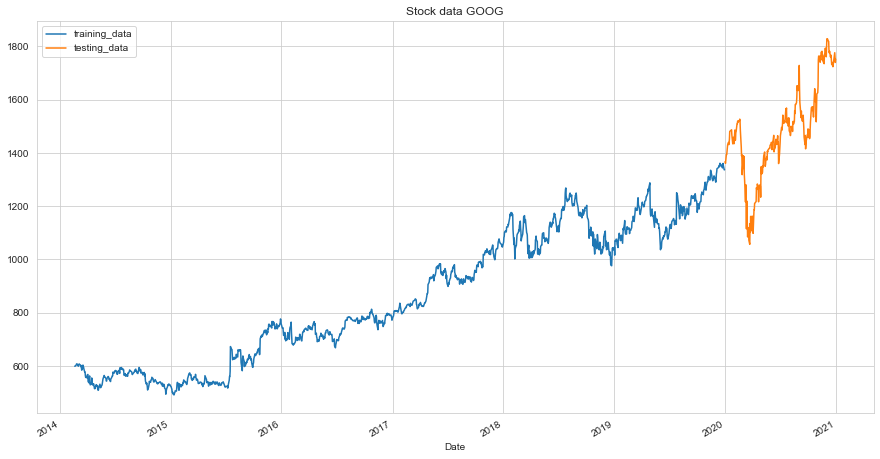

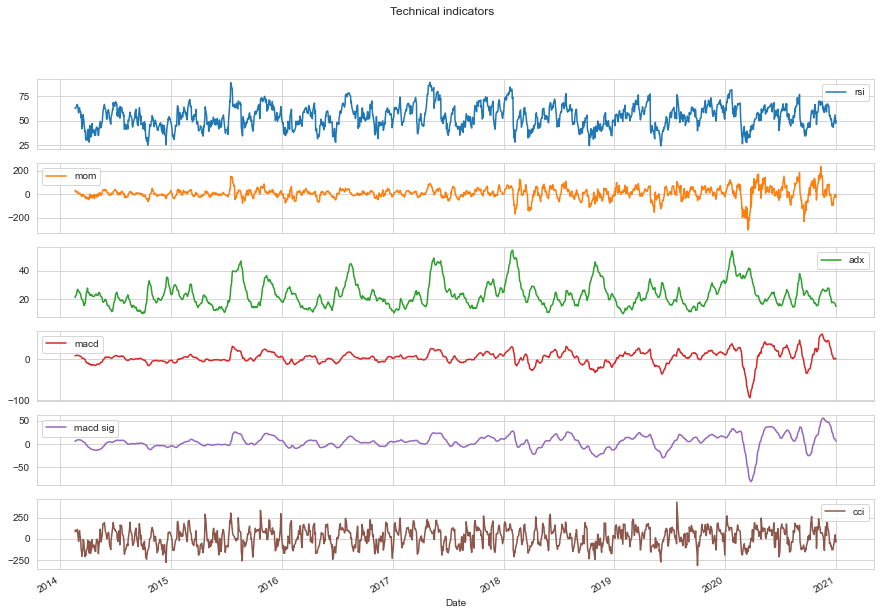

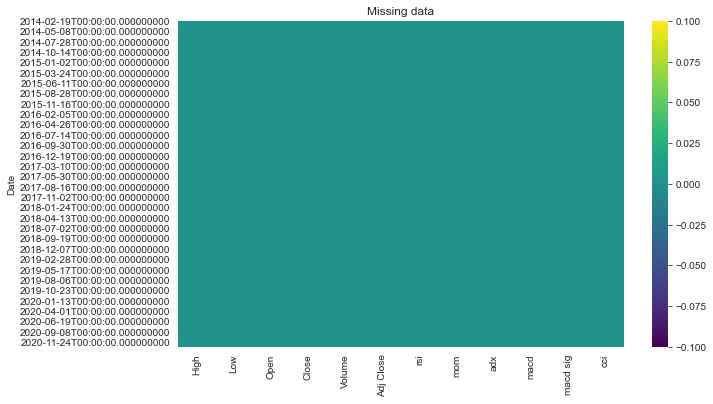

In [2]:
stock_name = 'goog'.upper()
stock_data = web.DataReader(stock_name, 'yahoo', '2014-01-01', '2021-01-01')
stock_data['rsi'] = talib.RSI(stock_data['Adj Close'])
stock_data['mom'] = talib.MOM(stock_data['Adj Close'])
stock_data['adx'] = talib.ADX(stock_data['High'], stock_data['Low'], stock_data['Adj Close'])
stock_data['macd'], stock_data['macd sig'], _ = talib.MACD(stock_data['Adj Close'])
stock_data['cci'] = talib.CCI(stock_data['High'], stock_data['Low'], stock_data['Adj Close'])
stock_data.dropna(axis=0, inplace=True)

train_data = stock_data.iloc[:-253]
test_data = stock_data.iloc[-253:]

sns.set_style('whitegrid')
train_data['Adj Close'].plot(label='training_data', figsize=(15,8));
test_data['Adj Close'].plot(label='testing_data');
plt.title('Stock data '+ stock_name)
plt.legend();
plt.show()

stock_data[['rsi', 'mom', 'adx', 'macd', 'macd sig', 'cci']].plot(subplots=True, figsize=(15,10), title='Technical indicators');
plt.show()


plt.figure(figsize=(10,6))
sns.heatmap(stock_data.isnull(), cmap='viridis');
plt.title('Missing data');
plt.show()

In [3]:
num_episodes = 500
capital = 1000000
position = 1000
train_env = SingleStockEnv(train_data, capital)
state_size = train_env.state_dim
action_size = len(train_env.action_space)
agent = QAgent(state_size, action_size)
scaler = get_scaler(train_env)

Training Model


  0%|          | 0/500 [00:00<?, ?it/s]

Episode:   25/500
Begin portfolio value: 1000000.00
End portfolio value:  824043.95
Epsilon: 0.00999
Sell: 93, Buy: 95
Reward: -175956.05
Mean Squared Error Loss: 10233.3805

Episode:   50/500
Begin portfolio value: 1000000.00
End portfolio value:  852092.38
Epsilon: 0.00999
Sell: 96, Buy: 98
Reward: -147907.62
Mean Squared Error Loss: 10233.8418

Episode:   75/500
Begin portfolio value: 1000000.00
End portfolio value:  846970.95
Epsilon: 0.00999
Sell: 97, Buy: 98
Reward: -153029.05
Mean Squared Error Loss:   0.2260

Episode:  100/500
Begin portfolio value: 1000000.00
End portfolio value:  862353.00
Epsilon: 0.00999
Sell: 97, Buy: 98
Reward: -137647.00
Mean Squared Error Loss:   0.2248

Episode:  125/500
Begin portfolio value: 1000000.00
End portfolio value:  811040.97
Epsilon: 0.00999
Sell: 97, Buy: 98
Reward: -188959.03
Mean Squared Error Loss:   0.2288

Episode:  150/500
Begin portfolio value: 1000000.00
End portfolio value:  855547.53
Epsilon: 0.00999
Sell: 99, Buy: 100
Reward: -14

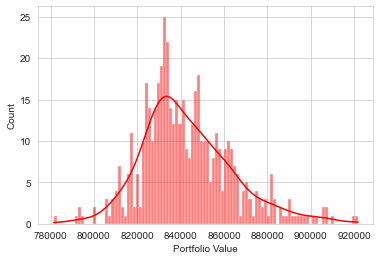

In [4]:
mode = 'train'

print('Training Model')
portfolio_value = []
reward = []
total_reward = np.zeros(num_episodes)
for e in tqdm(range(num_episodes)):
 
    state = train_env.reset()
    state = scaler.transform([state])
    done = False
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = train_env.step(action)
        next_state = scaler.transform([next_state])
        
        if mode == 'train':
            agent.train(state, action, reward, next_state, done)
        
        state = next_state
        total_reward[e] += reward
    
    if (e+1) % (num_episodes/20) == 0:     
        print(f"Episode: {e + 1:4}/{num_episodes}")
        print(f"Begin portfolio value: {capital:8.2f}")
        print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
        print(f"Epsilon: {agent.save_epsilon[-1]:2.5f}")
        print(f"Sell: {train_env.sell_buy.count('sell')}, Buy: {train_env.sell_buy.count('buy')}")
        print(f'Reward: {total_reward[e]:8.2f}')
        print(f"Mean Squared Error Loss: {agent.model.losses[-1]:8.4f}")
        print('=======================================================================')
        print()
    
    portfolio_value.append(info['portfolio_value'][-1]) 
    
       
agent.save(stock_name)
losses = agent.model.losses

print(f'average reward: {np.mean(portfolio_value):.2f}, min: {np.min(portfolio_value):.2f}, max: {np.max(portfolio_value):.2f}')
sns.histplot(portfolio_value, bins=100, color='r', kde=True);
plt.xlabel('Portfolio Value');
plt.ylabel('Count');

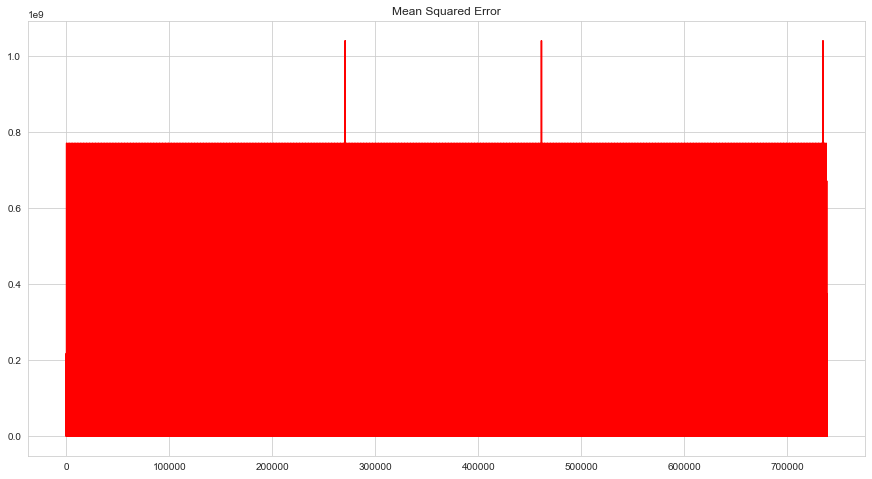

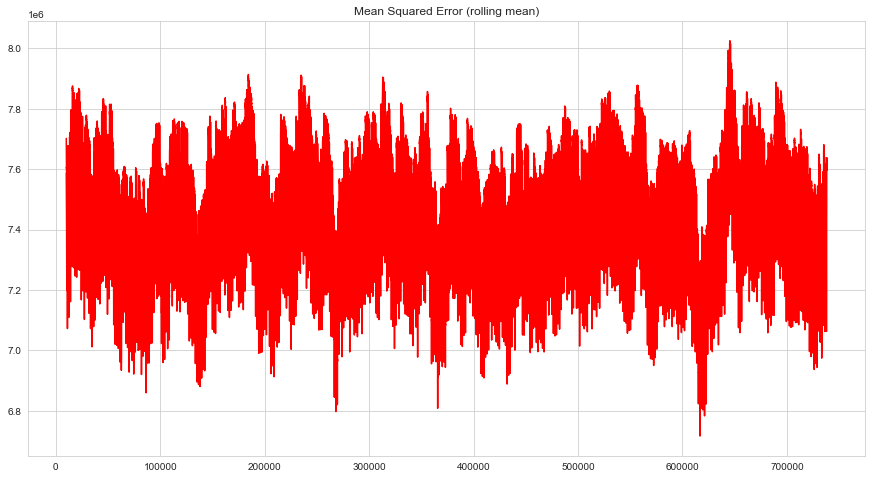

In [5]:
pd.Series(losses).plot(figsize=(15,8), c='r');
plt.title('Mean Squared Error');
plt.show()
pd.Series(losses).rolling(10000).mean().plot(figsize=(15,8), c='r');
plt.title('Mean Squared Error (rolling mean)');

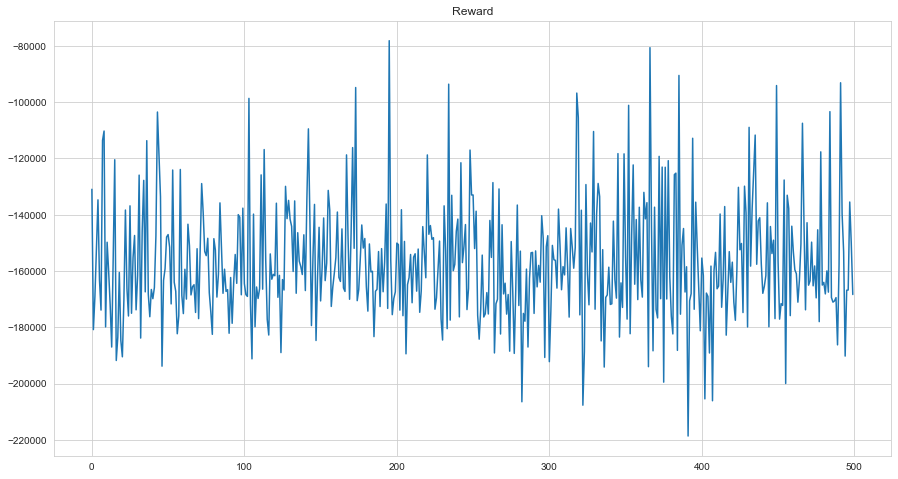

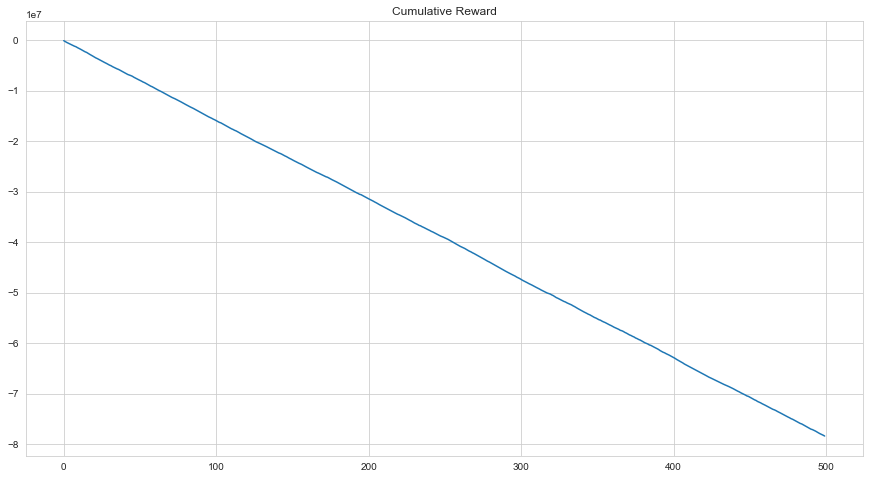

In [6]:
plt.figure(figsize=(15,8));
plt.plot(total_reward);
plt.title('Reward');
plt.show()
pd.Series(total_reward).cumsum().plot(figsize=(15,8));
plt.title('Cumulative Reward');

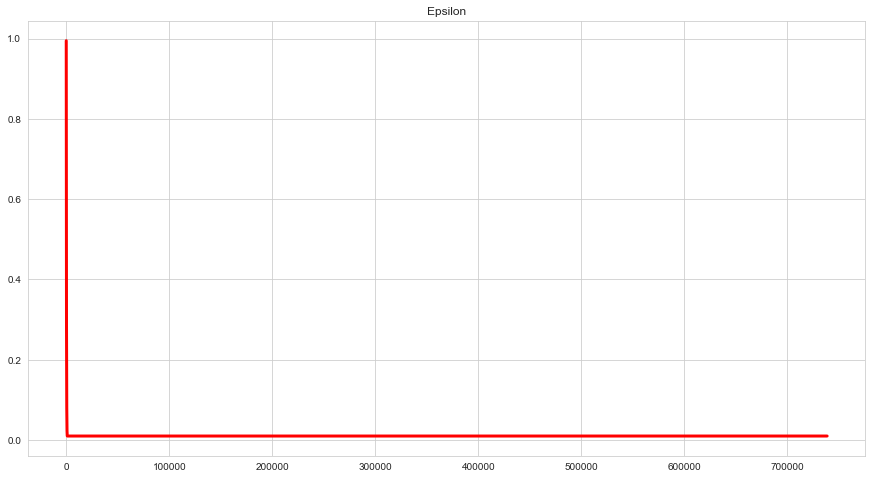

In [7]:
plt.figure(figsize=(15,8))
plt.plot(agent.save_epsilon, lw=3, c='r');plt.title('Epsilon');

Testing Model



Start: 2020-01-02 00:00:00  End: 2020-12-31 00:00:00
Since: 253 days
Begin portfolio value: 1000000.00
End portfolio value:  945041.14
Return -5.50 %
Sell: 39 times, Buy: 39 times


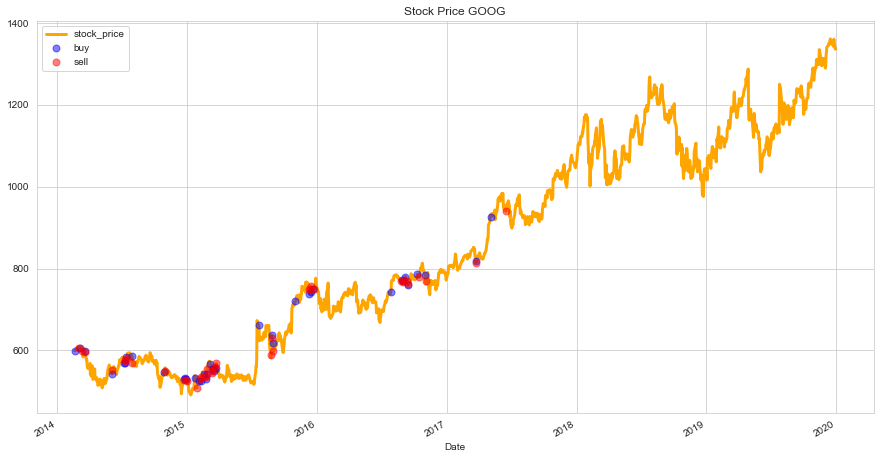

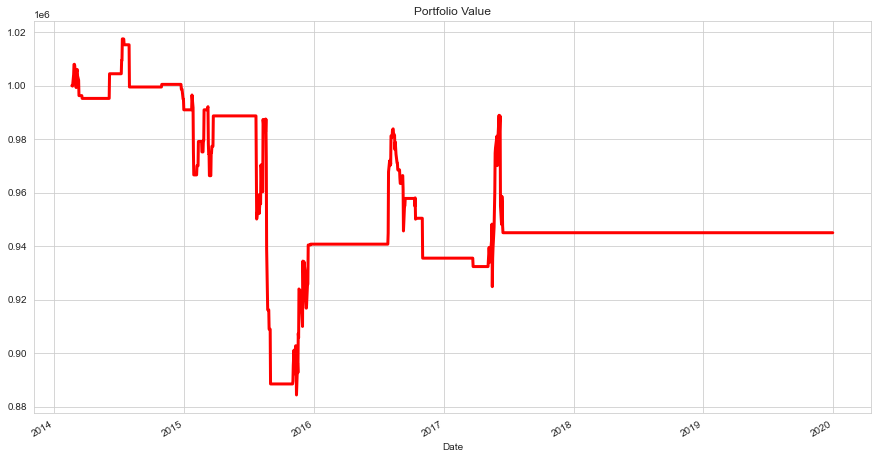

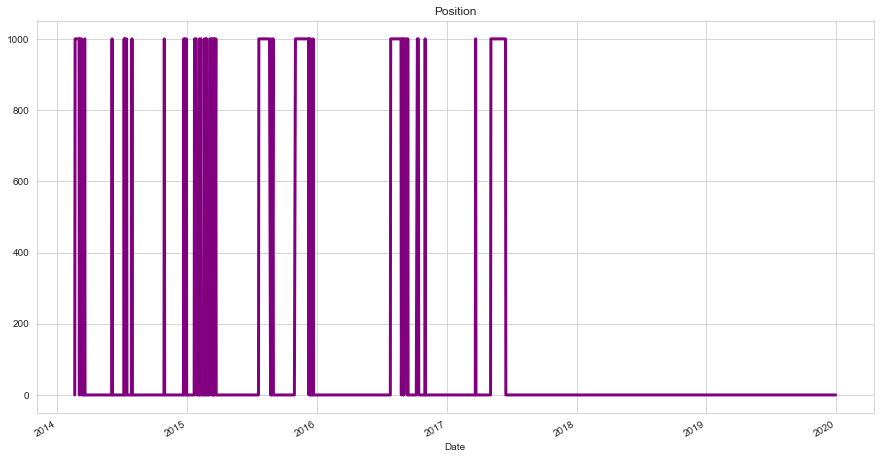

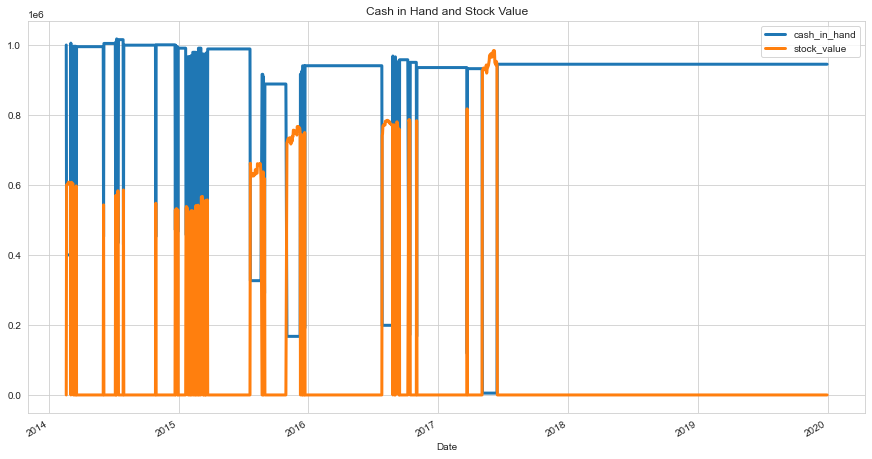

In [8]:

test_env = SingleStockEnv(train_data, capital, position)
state_size = test_env.state_dim
action_size = len(test_env.action_space)
agent = QAgent(state_size, action_size)

last_state = test_env.reset()
last_reward = 0
done = False
agent.load(f'{stock_name}.npz')
agent.epsilon = 0

while not done:
    action = agent.act(state)
    next_state, reward, done, info = test_env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state


print('Testing Model')
print('=======================================================================')
print('=======================================================================')
print()
print()
print()
print(f'Start: {test_data.index[0]}  End: {test_data.index[-1]}')
print(f'Since: {len(test_data)} days')
print(f"Begin portfolio value: {capital:8.2f}")
print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
print(f"Sell: {test_env.sell_buy.count('sell')} times, Buy: {test_env.sell_buy.count('buy')} times")
print('=======================================================================')

result = pd.DataFrame(info)
result.index = train_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(15,8), c='orange', lw='3');
result['marker_buy'].plot(style='o', ms=7, label='buy', c='b', alpha=0.5);
result['marker_sell'].plot(style='o', ms=7, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()

result['portfolio_value'].plot(figsize=(15,8), c='r', lw=3);
plt.title('Portfolio Value');
plt.show()

result['stock_owned'].plot(figsize=(15,8), c='purple', lw=3);
plt.title('Position')
plt.show()

result[['cash_in_hand', 'stock_value']].plot(figsize=(15,8), lw=3);
plt.title('Cash in Hand and Stock Value');
plt.show()

In [9]:
import numpy as np
import datetime as dt

bn = web.DataReader('spy', 'yahoo', '2020-01-01', '2021-01-01')
bn['Benchmark'] = bn['Adj Close']

def CAGR(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    
    df['cumulative_ret'] = (1 + df['daily_ret']).cumprod()
    n = len(df)/252
    cagr = (df['cumulative_ret'][-1])**(1/n) - 1
    return cagr

def volatility(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    vol = df['daily_ret'].std() * np.sqrt(252)
    return vol


def sharpe(DF, rf):
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    df['cumulative_ret'] = (1 + df['daily_ret']).cumprod()
    df['cum_roll_max'] = df['cumulative_ret'].cummax()
    df['drawdown'] = df['cum_roll_max'] - df['cumulative_ret']
    df['drawdown_pct'] = df['drawdown']/df['cum_roll_max']
    max_dd = df['drawdown_pct'].max()
    return max_dd

def calmer(DF):
    df = DF.copy()
    clmr = CAGR(df)/max_dd(df)
    return clmr



print(f'Stock name: {stock_name}')
print(f'Start: {result.index[0]}  End: {result.index[-1]}')
print(f'Compound Annual Growth Rate: {CAGR(result)*100:.2f} %')
print(f'Volatility: {volatility(result):.4f}')
print(f'shape ratio: {sharpe(result, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(result)*-100:.2f} %')
print(f'Calmar ratio: {calmer(result):.4f}')
print()
print('Comparing with Benchmark')
print(f'Compound Annual Growth Rate (benchmark): {CAGR(bn)*100:.2f} %')
print(f'Volatility (benchmark): {volatility(bn):.4f}')
print(f'shape ratio: {sharpe(bn, 0.011):.4f}')
print(f'Calmar ratio (benchmark): {calmer(bn):.4f}')

Stock name: GOOG
Start: 2014-02-19 00:00:00  End: 2019-12-31 00:00:00
Compound Annual Growth Rate: -0.96 %
Volatility: 0.0494
shape ratio: -0.4167
Maximun drawdown: -13.08 %
Calmar ratio: -0.0733

Comparing with Benchmark
Compound Annual Growth Rate (benchmark): 18.17 %
Volatility (benchmark): 0.3340
shape ratio: 0.5113
Calmar ratio (benchmark): 0.5390


In [10]:
bt_returns = result['portfolio_value'].pct_change()
bm_returns = bn['Benchmark'].pct_change()
price = test_data['Adj Close'].pct_change()

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: DatetimeIndex(['2014-02-19', '2014-02-20', '2014-02-21', '2014-02-24',\n               '2014-02-25',\n               ...\n               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',\n               '2019-12-30'],\n              dtype='datetime64[ns]', name='Date', length=1477, freq=None). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

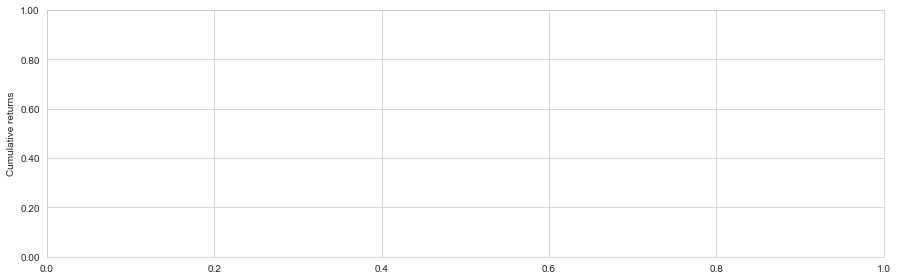

In [11]:
plt.figure(figsize=(15,10));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, bm_returns);
plt.title('Compare with Benchmark');

KeyError: "None of [DatetimeIndex(['2014-02-19', '2014-02-20', '2014-02-21', '2014-02-24',\n               '2014-02-25', '2014-02-26', '2014-02-27', '2014-02-28',\n               '2014-03-03', '2014-03-04',\n               ...\n               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',\n               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',\n               '2019-12-30', '2019-12-31'],\n              dtype='datetime64[ns]', name='Date', length=1478, freq=None)] are in the [index]"

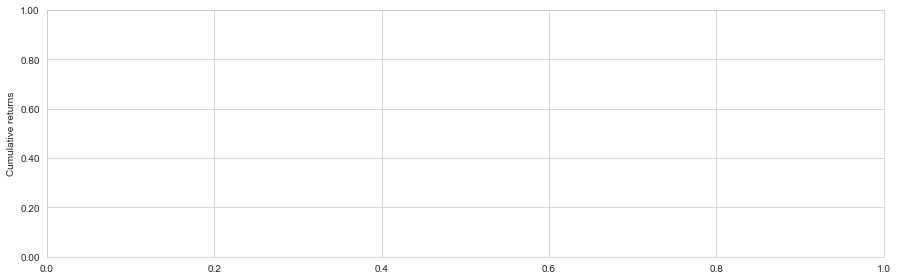

In [13]:
plt.figure(figsize=(15,10));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, price);
plt.title('Compare with close price');

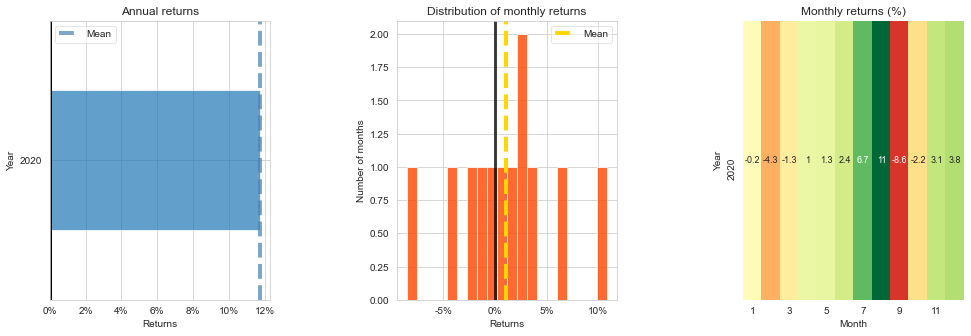

In [18]:
fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(bt_returns)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(bt_returns)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(bt_returns)
plt.tight_layout()
fig.set_size_inches(15,5)

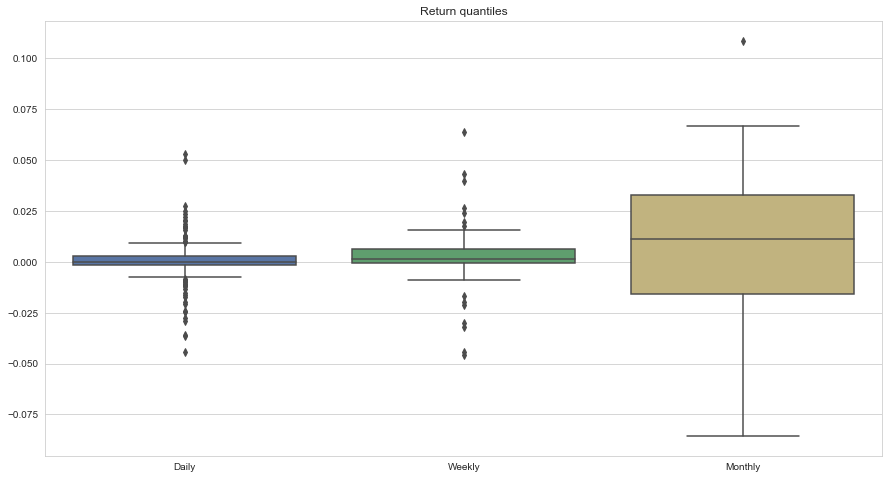

In [19]:
plt.figure(figsize=(15,8))
pf.plot_return_quantiles(bt_returns);

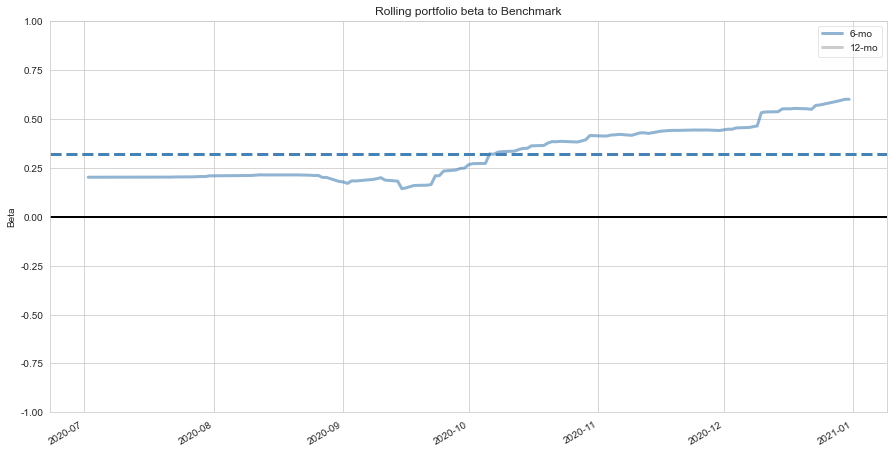

In [20]:
plt.figure(figsize=(15,8))
pf.plot_rolling_beta(bt_returns, bm_returns);

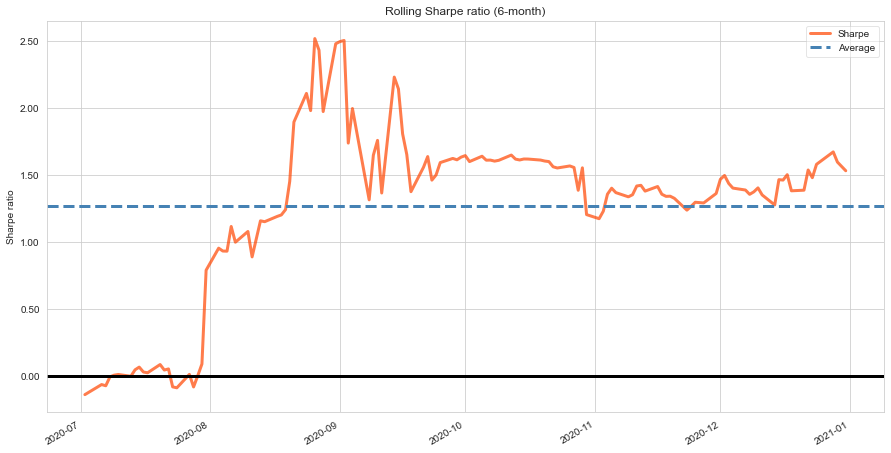

In [21]:
plt.figure(figsize=(15,8))
pf.plot_rolling_sharpe(bt_returns);

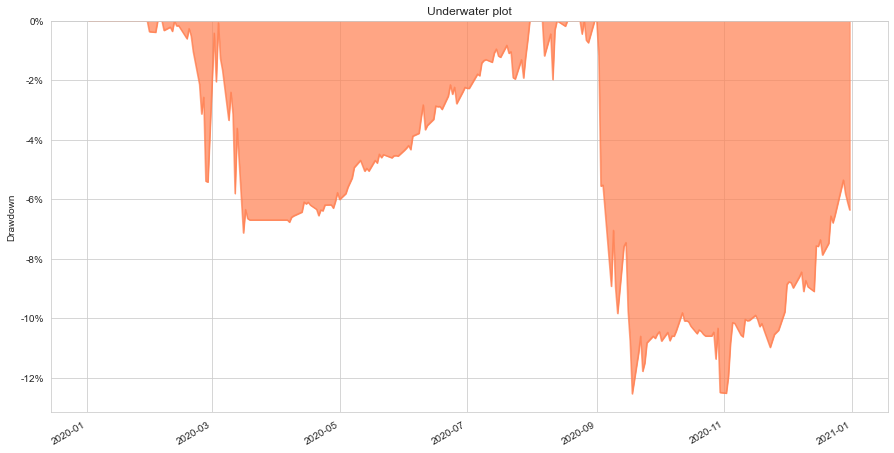

In [22]:
plt.figure(figsize=(15,8))
pf.plot_drawdown_underwater(bt_returns);